In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score, auc, RocCurveDisplay, roc_curve, confusion_matrix
sys.path.append("..")
from src import *

2024-10-29 11:39:29.704474: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-29 11:39:29.716040: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-29 11:39:29.731540: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-29 11:39:29.736378: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-29 11:39:29.747574: I tensorflow/core/platform/cpu_feature_guar

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
config_path =  "/data_nfs/je30bery/archive/melanoma_data/config.json"

In [4]:
data = get_data_csv(groups=["Melanoma"], high_quality_only=False, pfs=True, config_path=config_path)
data["Sex"].replace({"m": 1., "f": 0.}, inplace=True)
data["Ulcerated"].replace({True: 1., False: 0.}, inplace=True)

In [5]:
np.unique(data["PFS < 5"], return_counts=True)

(array([0., 1.]), array([97, 15]))

In [6]:
prediction, feature_imp = loo_forest(data, features=["Sex", "Age", "Tumor Thickness [mm]", "Ulcerated", "Coarse loc.", "Side"], label="PFS < 5")
data = data.sort_values("Histo ID", axis=0).set_index("Histo ID")
prediction = prediction.sort_values("Histo ID", axis=0).set_index("Histo ID")
data["RFC all features"] = prediction["Prediction"]

In [7]:
data = data.reset_index() #.drop("index", axis=1)
prediction, _ = loo_forest(data=data, features=["Tumor Thickness [mm]"], label="PFS < 5")
data = data.sort_values("Histo ID", axis=0).set_index("Histo ID")
prediction = prediction.sort_values("Histo ID", axis=0).set_index("Histo ID")
data["RFC TT"] = prediction["Prediction"]

In [8]:
data = data.reset_index() #.drop("index", axis=1)
prediction, _ = loo_forest(data=data.reset_index(), features=["Sex", "Age", "Ulcerated", "Coarse loc.", "Side"], label="PFS < 5")
data = data.sort_values("Histo ID", axis=0).set_index("Histo ID")
prediction = prediction.sort_values("Histo ID", axis=0).set_index("Histo ID")
data["RFC w/o TT"] = prediction["Prediction"]
data = data.reset_index() 

In [9]:
data["RFC deep features"] = 0

In [10]:
v, c = np.unique(data["PFS < 5"], return_counts=True)
p0 = c[0] / np.sum(c)
p1 = 1 - p0
print(v, c, p0, p1)
data["Biased random classifier"] = np.random.choice(a=v, size=len(data), p=[p0, p1])

[0. 1.] [97 15] 0.8660714285714286 0.1339285714285714


In [11]:
data[["Patient ID", "PFS < 5"]].drop_duplicates()

,Patient ID,PFS < 5
0,0,0.0
10,3,0.0
16,4,0.0
20,5,0.0
26,6,0.0
32,7,1.0
33,8,0.0
40,9,0.0
45,10,0.0
61,13,0.0


In [12]:
v, c = np.unique(data[["Patient ID", "PFS < 5"]].drop_duplicates()["PFS < 5"], return_counts=True)
print(v, c)
p0 = c[0] / np.sum(c)
p1 = 1 - p0
labels = np.random.choice(a=v, size=len(data[["Patient ID", "PFS < 5"]].drop_duplicates()), p=[p0, p1])

patients = np.unique(data[["Patient ID", "PFS < 5"]].drop_duplicates()["Patient ID"])
for i, patient in enumerate(patients):
    data.loc[data["Patient ID"] == patient, "Patient-level biased random classifier"] = labels[i]

[0. 1.] [14  8]


In [13]:
len(data[["Patient ID", "PFS < 5", "Patient-level biased random classifier"]].drop_duplicates())

22

In [14]:
np.unique(data[["Patient ID", "PFS < 5", "Patient-level biased random classifier"]].drop_duplicates()["Patient-level biased random classifier"], return_counts=True)

(array([0., 1.]), array([16,  6]))

In [15]:
with open(config_path, "r") as f:
    configs = json.load(f)
    
dataset_statistics = configs["dataset_statistics"]
checkpoint_path = configs["downloaded_model_weights"]
pretrained_model = configs["pretrained_model_path"]
finetuned_models_path = configs["finetuned_models"]

with open(os.path.join(dataset_statistics, f'melanoma_means.json'), 'r') as fp:
    means = json.load(fp)
    markers = list(means.keys())

In [16]:
data.columns

Index(['Histo ID', 'MELC image', 'Patient ID', 'Sex', 'Age',
       'Tumor Thickness [mm]', 'Ulcerated', 'Coarse loc.', 'Side', 'Group',
       'PFS < 5', 'High-quality segmentation result', 'RFC all features',
       'RFC TT', 'RFC w/o TT', 'RFC deep features', 'Biased random classifier',
       'Patient-level biased random classifier'],
      dtype='object')

In [17]:
no_dup = data[["Sex", "Age", "Patient ID", "PFS < 5", "Ulcerated", "Side", "Coarse loc.", "Tumor Thickness [mm]"]].drop_duplicates()

In [18]:
splits = {0: [16],
 1: [29],
 2: [33],
 3: [8, 15, 18, 19, 20],
 4: [25],
 5: [9],
 6: [21],
 7: [5],
 8: [30],
 9: [17],
 10: [3],
 11: [26],
 12: [32],
 13: [4],
 14: [24],
 15: [11, 12],
 16: [0],
 17: [7],
 18: [22, 34],
 19: [28],
 20: [27],
 21: [6]}

In [19]:
data

,Histo ID,MELC image,Patient ID,Sex,Age,Tumor Thickness [mm],Ulcerated,Coarse loc.,Side,Group,PFS < 5,High-quality segmentation result,RFC all features,RFC TT,RFC w/o TT,RFC deep features,Biased random classifier,Patient-level biased random classifier
0,0,image-002,0,1.0,58,1.3,0.0,4.0,1.0,Melanoma,0.0,False,0.0,0.0,0.0,0,0.0,0.0
1,0,image-046,0,1.0,58,1.3,0.0,4.0,1.0,Melanoma,0.0,True,0.0,0.0,0.0,0,0.0,0.0
2,0,image-023,0,1.0,58,1.3,0.0,4.0,1.0,Melanoma,0.0,True,0.0,0.0,0.0,0,0.0,0.0
3,0,image-000,0,1.0,58,1.3,0.0,4.0,1.0,Melanoma,0.0,False,0.0,0.0,0.0,0,0.0,0.0
4,0,image-001,0,1.0,58,1.3,0.0,4.0,1.0,Melanoma,0.0,False,0.0,0.0,0.0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,32,image-112,26,1.0,48,6.0,1.0,0.0,-1.0,Melanoma,1.0,False,0.0,0.0,0.0,0,0.0,0.0
108,33,image-117,27,1.0,52,2.6,0.0,2.0,1.0,Melanoma,1.0,True,0.0,1.0,0.0,0,0.0,0.0
109,33,image-118,27,1.0,52,2.6,0.0,2.0,1.0,Melanoma,1.0,True,0.0,1.0,0.0,0,0.0,0.0
110,34,image-120,16,1.0,36,4.1,0.0,2.0,1.0,Melanoma,0.0,True,1.0,0.0,1.0,0,0.0,0.0


In [20]:
model = ResNet18_smoothgrad(indim=len(markers), cam=True, checkpoint_path=checkpoint_path)
model = model.to("cuda:0")
finetuned_models = os.listdir(finetuned_models_path)
subsets = list()

for split in tqdm(splits):
    data_subset = data[data["Histo ID"].isin(splits[split])]

    if len(data_subset) == 0:
        continue
    dl = t.utils.data.DataLoader(MelanomaData(markers, pretrain=False, data=data_subset, mode="val", config_path=config_path), batch_size=1, shuffle=False)
    model_path = [m for m in finetuned_models if f"finetuning_final_split={split}" in m][0]
    model.load_state_dict(t.load(os.path.join(finetuned_models_path, model_path), map_location="cuda:0"), strict=True)
    model.eval()
    it = iter(dl)
    preds = list()
    for i in range(len(data_subset)):
        x, y, _ = next(it)
        y_pred = model(x.cuda()).detach().cpu().numpy().item()
        preds.append(y_pred)     
    data.loc[data["Histo ID"].isin(splits[split]), "Prediction"] = preds    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:38<00:00,  1.77s/it]


In [21]:
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()  
    specificity = tn / (tn + fp)
    return specificity
    
def sensitivity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    return sensitivity

In [22]:
def get_levelled_preds(data, prediction_label="Prediction", return_preds=False):
    data = data.copy().dropna(subset=[prediction_label], axis=0)
    histo_level_labels = list()
    histo_level_preds = list()

    for histo_id in np.unique(data["Histo ID"]):
        data_subset = data[data["Histo ID"] == histo_id]
        if len(data_subset) > 0:
            label = data_subset["PFS < 5"]
            histo_level_labels.append(np.unique(label)[0])
            pred = np.mean(data_subset[prediction_label])
            histo_level_preds.append(pred)

    pat_level_labels = list()
    pat_level_preds = list()
    for split in tqdm(splits):
        data_subset = data[data["Histo ID"].isin(splits[split])]

        if len(data_subset) > 0:
            label = data_subset["PFS < 5"]
            pat_level_labels.append(np.unique(label)[0])
            pred = np.mean(data_subset[prediction_label])
            pat_level_preds.append(pred)

    if return_preds:
        return histo_level_labels, histo_level_preds, pat_level_labels, pat_level_preds
        
    d = list()
    for i, (y_true, y_pred) in enumerate([(data["PFS < 5"], data[prediction_label]), (histo_level_labels, histo_level_preds), (pat_level_labels, pat_level_preds)]):
        d.append(pd.DataFrame([accuracy_score(y_true, np.array(y_pred)>0.5),
                               roc_auc_score(y_true, y_pred), 
                               f1_score(y_true, np.array(y_pred)>0.5),
                               specificity(y_true, np.array(y_pred)>0.5),
                               sensitivity(y_true, np.array(y_pred)>0.5)],
                              index=["Accuracy", "AUC-ROC", "F1-score","Specificity","Sensitivity"]))
    df = pd.concat(d, axis=1)
    df.columns = ["Sample-level", "Section-level", "Patient-level"]
    return df

In [23]:
def get_roc_auc(ax, y_true, y_score, label, color):
    fpr, tpr, thresholds = roc_curve(y_true=y_true, y_score=y_score)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    display.plot(ax=ax, label=label, color=color, alpha=0.8) #
    return ax

In [28]:
dfs = dict()
accs = dict()
auc_rocs = dict()
for prediction_label in ['RFC all features', 'RFC TT', 'RFC w/o TT',  "Biased random classifier","Patient-level biased random classifier",  'Prediction']:
    res = get_levelled_preds(data, prediction_label)
    dfs[prediction_label] = res
    accs[prediction_label] = pd.DataFrame(res.loc["Accuracy"])
    auc_rocs[prediction_label] = pd.DataFrame(res.loc["AUC-ROC"])
accs = pd.concat(accs, axis=1).T.reset_index().drop("level_1", axis=1).set_index("level_0")
auc_rocs = pd.concat(auc_rocs, axis=1).T.reset_index().drop("level_1", axis=1).set_index("level_0")
accs.iloc[0:3, 0] = np.nan
auc_rocs.iloc[0:3, 0] = np.nan
accs.index =  ["RFC on all meta variables", "RFC on tumor thickness only", "RFC on all, tumor thickness excluded", "Biased random classifier", "Patient-level biased random classifier", "Cross-validated CNN"]
auc_rocs.index =  ["RFC on all meta variables", "RFC on tumor thickness only", "RFC on all, tumor thickness excluded", "Biased random classifier", "Patient-level biased random classifier", "Cross-validated CNN"]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 2588.13it/s]


In [29]:
print(pd.concat(dfs).round(2).to_latex())

\begin{tabular}{llrrr}
\toprule
 &  & Sample-level & Section-level & Patient-level \\
\midrule
\multirow[t]{5}{*}{RFC all features} & Accuracy & 0.900000 & 0.790000 & 0.770000 \\
 & AUC-ROC & 0.750000 & 0.700000 & 0.710000 \\
 & F1-score & 0.590000 & 0.570000 & 0.620000 \\
 & Specificity & 0.960000 & 0.900000 & 0.930000 \\
 & Sensitivity & 0.530000 & 0.500000 & 0.500000 \\
\cline{1-5}
\multirow[t]{5}{*}{RFC TT} & Accuracy & 0.820000 & 0.820000 & 0.820000 \\
 & AUC-ROC & 0.840000 & 0.840000 & 0.830000 \\
 & F1-score & 0.570000 & 0.740000 & 0.780000 \\
 & Specificity & 0.810000 & 0.800000 & 0.790000 \\
 & Sensitivity & 0.870000 & 0.880000 & 0.880000 \\
\cline{1-5}
\multirow[t]{5}{*}{RFC w/o TT} & Accuracy & 0.800000 & 0.680000 & 0.680000 \\
 & AUC-ROC & 0.580000 & 0.550000 & 0.560000 \\
 & F1-score & 0.270000 & 0.310000 & 0.360000 \\
 & Specificity & 0.890000 & 0.850000 & 0.930000 \\
 & Sensitivity & 0.270000 & 0.250000 & 0.250000 \\
\cline{1-5}
\multirow[t]{5}{*}{Biased random classifie

In [30]:
histo_level_labels, histo_level_preds, pat_level_labels, pat_level_preds =  get_levelled_preds(data, prediction_label="Prediction", return_preds=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 2379.19it/s]


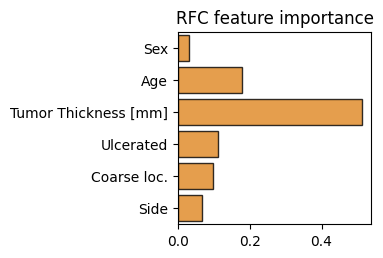

In [36]:
fig, ax = plt.subplots(1, figsize=(2.5, 2.5))
#feature_imp.rename({"Tumor Thickness [mm]": "Tumor\nthickness"}, inplace=True, axis=1)
sns.barplot(feature_imp, color="#ff8800", alpha=0.8, ax=ax, edgecolor="0.", orient="h")
    #plt.title(f'Feature importance of Random Forest with\nleave-one-patient-out approach')
ax.set_title('RFC feature importance')
#axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, ha='right')
plt.savefig("../result_plots/fimp.svg", bbox_inches="tight")

<Figure size 640x480 with 0 Axes>

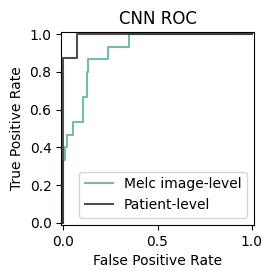

In [37]:
plt.clf()
fig, ax = plt.subplots(1, figsize=(2.5, 2.5))

get_roc_auc(ax, data["PFS < 5"], data["Prediction"], label="Melc image-level", color=sns.color_palette("dark:#5A9_r", 3)[0])
#get_roc_auc(ax, histo_level_labels, histo_level_preds, label="Section-level", color=sns.color_palette("dark:#5A9_r", 3)[1])
get_roc_auc(ax, pat_level_labels, pat_level_preds, label="Patient-level", color=sns.color_palette("dark:#5A9_r", 3)[2])

#axs[0].text(-0.2, -0.9, "c", ha='center', va='bottom', weight="bold", size=12)
#axs[1].text(0, 1.07, "d", ha='center', va='bottom', weight="bold")
#axs[2].text(0, 1.07, "e", ha='center', va='bottom', weight="bold")

ax.set_title("CNN ROC")
#axs[1].text(-0.45, 1.15, "d", ha='center', va='bottom', weight="bold", size=12)

#plt.subplots_adjust(hspace=0.4)
#axs[1].set_title("Section-level")
#axs[2].set_title("Patient-level")
#plt.tight_layout()
plt.savefig("../result_plots/ROCS.svg", bbox_inches="tight")

<Figure size 640x480 with 0 Axes>

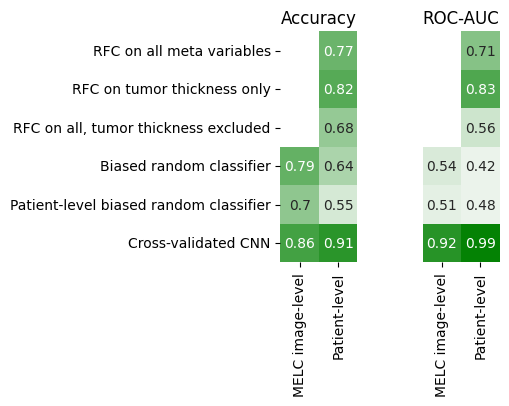

In [39]:
plt.clf()
palette = sns.light_palette("green", as_cmap=True)
f, axs = plt.subplots(1, 2, sharey=True, figsize=(5.5, 3))
#accs.drop(["Section-level"], axis=1, inplace=True)
#auc_rocs.drop(["Section-level"], axis=1, inplace=True)

accs.rename({"Sample-level": "MELC image-level"}, inplace=True, axis=1)
auc_rocs.rename({"Sample-level": "MELC image-level"}, inplace=True, axis=1)

sns.heatmap(accs, annot=True, square=True, cbar=False, ax=axs[0], cmap=palette, vmin=0.5, vmax=1)
sns.heatmap(auc_rocs, annot=True, square=True, cbar=False, ax=axs[1], cmap=palette, vmin=0.5, vmax=1)
axs[1].get_yaxis().set_visible(False)
axs[0].set_title("Accuracy")
axs[1].set_title("ROC-AUC")
#axs[0].text(-6, -0.1, "a", ha='center', va='bottom', weight="bold")
plt.subplots_adjust(wspace=-0.5)
#plt.tight_layout()
plt.savefig("../result_plots/Acc.svg", bbox_inches="tight")

In [40]:
model = ResNet18_smoothgrad(indim=len(markers), cam=True, checkpoint_path=checkpoint_path)
model = model.to("cuda:0")
finetuned_models = os.listdir(finetuned_models_path)
data["Prediction LO"] = np.nan
subsets = list()

for split in tqdm(splits):
    if split not in [0, 1, 2, 5, 8, 13, 18]:
        continue
    data_subset = data[data["Histo ID"].isin(splits[split])]
    if len(data_subset) == 0:
        continue
    dl = t.utils.data.DataLoader(MelanomaData(markers, pretrain=False, data=data_subset, mode="val", config_path=config_path), batch_size=1, shuffle=False)
    model_path = [m for m in finetuned_models if f"finetuned_{split}" in m][0]
    model.load_state_dict(t.load(os.path.join(finetuned_models_path, model_path), map_location="cuda:0"), strict=True)
    model.eval()
    it = iter(dl)
    preds = list()
    for i in range(len(data_subset)):
        x, y, _ = next(it)
        y_pred = model(x.cuda()).detach().cpu().numpy().item()
        preds.append(y_pred)     
    data.loc[data["Histo ID"].isin(splits[split]), "Prediction LO"] = preds

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:07<00:00,  2.87it/s]


In [43]:
dfs = dict()
lo_accs = dict()
lo_auc_rocs = dict()
subset = data.dropna(subset=["Prediction LO"])
subset = data[data["Histo ID"].isin(splits[1] + splits[2] + splits[0] + splits[13])]

print(len(subset))
for prediction_label in ['Prediction', 'Prediction LO']:
    res = get_levelled_preds(subset, prediction_label)
    dfs[prediction_label] = res
    lo_accs[prediction_label] = pd.DataFrame(res.loc["Accuracy"])
    lo_auc_rocs[prediction_label] = pd.DataFrame(res.loc["AUC-ROC"])
lo_accs = pd.concat(lo_accs, axis=1).T.reset_index().drop("level_1", axis=1).set_index("level_0")
lo_auc_rocs = pd.concat(lo_auc_rocs, axis=1).T.reset_index().drop("level_1", axis=1).set_index("level_0")

lo_accs.drop(["Section-level"], axis=1, inplace=True)
lo_auc_rocs.drop(["Section-level"], axis=1, inplace=True)

lo_accs.rename({"Sample-level": "MELC image-level"}, inplace=True, axis=1)
lo_auc_rocs.rename({"Sample-level": "MELC image-level"}, inplace=True, axis=1)

lo_accs.index = ["Pre-training on all", "Pre-training without CV sample"]
lo_auc_rocs.index = ["Pre-training on all", "Pre-training without CV sample"]

lo_accs

12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 3133.69it/s]


,MELC image-level,Patient-level
Pre-training on all,0.833333,1.0
Pre-training without CV sample,0.666667,1.0


In [44]:
print(pd.concat(dfs).round(2).to_latex())

\begin{tabular}{llrrr}
\toprule
 &  & Sample-level & Section-level & Patient-level \\
\midrule
\multirow[t]{5}{*}{Prediction} & Accuracy & 0.830000 & 1.000000 & 1.000000 \\
 & AUC-ROC & 0.970000 & 1.000000 & 1.000000 \\
 & F1-score & 0.750000 & 1.000000 & 1.000000 \\
 & Specificity & 0.880000 & 1.000000 & 1.000000 \\
 & Sensitivity & 0.750000 & 1.000000 & 1.000000 \\
\cline{1-5}
\multirow[t]{5}{*}{Prediction LO} & Accuracy & 0.670000 & 1.000000 & 1.000000 \\
 & AUC-ROC & 0.810000 & 1.000000 & 1.000000 \\
 & F1-score & 0.500000 & 1.000000 & 1.000000 \\
 & Specificity & 0.750000 & 1.000000 & 1.000000 \\
 & Sensitivity & 0.500000 & 1.000000 & 1.000000 \\
\cline{1-5}
\bottomrule
\end{tabular}



<Figure size 640x480 with 0 Axes>

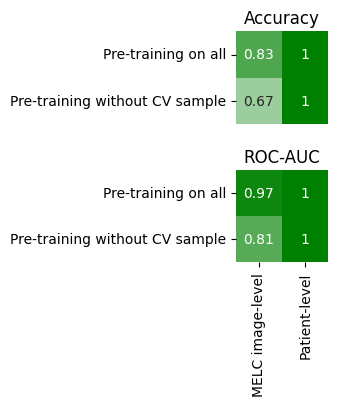

In [51]:
plt.clf()
palette = sns.light_palette("green", as_cmap=True)

f, axs = plt.subplots(2, figsize=(5, 3), sharex=True)
sns.heatmap(lo_accs, annot=True, square=True, cbar=False, ax=axs[0], cmap=palette, vmin=0.5, vmax=1)
sns.heatmap(lo_auc_rocs, annot=True, square=True, cbar=False, ax=axs[1], cmap=palette, vmin=0.5, vmax=1)
axs[0].get_xaxis().set_visible(False)
axs[0].set_title("Accuracy")
axs[1].set_title("\nROC-AUC")
#axs[0].text(-4.8, -0.2, "b", ha='center', va='bottom', weight="bold")
plt.subplots_adjust(hspace=0.5)
plt.savefig("../result_plots/LO.svg", bbox_inches="tight")
plt.show()

In [46]:
data_subset1 = data[(data["Sex"] == 0)]
data_subset2 = data[(data["Sex"] == 1)]
data_subset3 = data[(data["Age"].astype(int) <= 62)]
data_subset4 = data[(data["Age"].astype(int) > 62)]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 3398.20it/s]


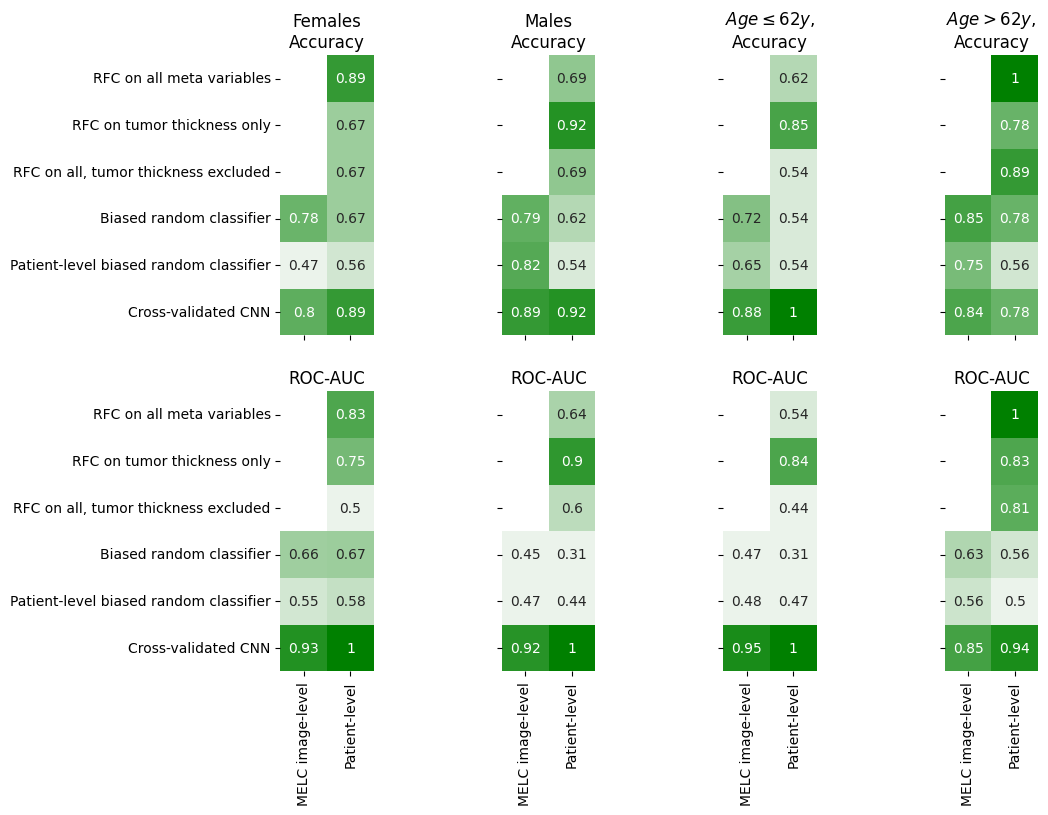

In [50]:
f, axs = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(10, 8))

for i, data_subset in enumerate([data_subset1, data_subset2, data_subset3, data_subset4]):
    dfs = dict()
    accs = dict()
    auc_rocs = dict()
    for prediction_label in ['RFC all features', 'RFC TT', 'RFC w/o TT',  "Biased random classifier","Patient-level biased random classifier",  'Prediction']:
        res = get_levelled_preds(data_subset, prediction_label)
        dfs[prediction_label] = res
        accs[prediction_label] = pd.DataFrame(res.loc["Accuracy"])
        auc_rocs[prediction_label] = pd.DataFrame(res.loc["AUC-ROC"])
    accs = pd.concat(accs, axis=1).T.reset_index().drop("level_1", axis=1).set_index("level_0")
    auc_rocs = pd.concat(auc_rocs, axis=1).T.reset_index().drop("level_1", axis=1).set_index("level_0")
    accs.iloc[0:3, 0] = np.nan
    auc_rocs.iloc[0:3, 0] = np.nan
    accs.index =   ["RFC on all meta variables", "RFC on tumor thickness only", "RFC on all, tumor thickness excluded", "Biased random classifier", "Patient-level biased random classifier", "Cross-validated CNN"]
    auc_rocs.index =  ["RFC on all meta variables", "RFC on tumor thickness only", "RFC on all, tumor thickness excluded", "Biased random classifier", "Patient-level biased random classifier", "Cross-validated CNN"]
    accs.drop(["Section-level"], axis=1, inplace=True)
    auc_rocs.drop(["Section-level"], axis=1, inplace=True)

    accs.rename({"Sample-level": "MELC image-level"}, inplace=True, axis=1)
    auc_rocs.rename({"Sample-level": "MELC image-level"}, inplace=True, axis=1)

    
    palette = sns.light_palette("green", as_cmap=True)
    ax0 = axs[i // 4, i]
    ax1 = axs[i // 4 + 1, i]
    sns.heatmap(accs, annot=True, square=True, cbar=False, ax=ax0, cmap=palette, vmin=0.5, vmax=1)
    sns.heatmap(auc_rocs, annot=True, square=True, cbar=False, ax=ax1, cmap=palette, vmin=0.5, vmax=1)
    ax0.set_title("Accuracy")
    ax1.set_title("ROC-AUC")
    #axs[i // 2, i % 2].get_yaxis().set_visible(False)

    #axs[0].text(-6, -0.1, "a", ha='center', va='bottom', weight="bold")
axs[0, 0].set_title("Females\nAccuracy")
axs[0, 1].set_title("Males\nAccuracy")
axs[0, 2].set_title("$Age \leq 62y$,\nAccuracy")
axs[0, 3].set_title("$Age > 62y$,\nAccuracy")
plt.subplots_adjust(wspace=1)
plt.savefig("../result_plots/gender_age_wise_performace.svg", bbox_inches="tight")

In [48]:
accs

,MELC image-level,Patient-level
RFC on all meta variables,NaN,1.000000
RFC on tumor thickness only,NaN,0.777778
"RFC on all, tumor thickness excluded",NaN,0.888889
RFC on deep model features,0.890909,0.666667
Cross-validated CNN,0.836364,0.777778
Biased random classifier,0.854545,0.777778
